# Stacking Models Common Utils

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import lightgbm as lgb
import numpy as np
import xgboost as xgb
from catboost import CatBoost, Pool
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold, GridSearchCV

NEGATIVE_SCALE = 50
training_folder = './data/train/'
test_folder = './data/test/'
csv_folder = './data/csv/'

training_file = training_folder + 'features_' + str(NEGATIVE_SCALE) + '.csv'
validation_file = training_folder + 'validation_' + str(NEGATIVE_SCALE) + '.csv'
training_pd = pd.read_csv(training_file)
validation_pd = pd.read_csv(validation_file)
# Partial data frames used for quicker gorupby
training_pd_part = training_pd[['query_id', 'doc_id']]
validation_pd_part = validation_pd[['query_id', 'doc_id']]

def get_group(fold_part):
    fold_part['group'] = fold_part.groupby('query_id')['query_id'].transform('size')
    group = fold_part[['query_id', 'group']].drop_duplicates()['group']
    return group

def get_eval_group(fold_part):
    group = fold_part.groupby('query_id')['query_id'].transform('size')
    return group

def get_dataset(df):
    return df[feat_name], df['relevance']

feat_name = []
for col in training_pd:
    if 'feat_' in col:
        feat_name.append(col)

for feat in feat_name:
    training_pd[feat] = pd.to_numeric(training_pd[feat])
    validation_pd[feat] = pd.to_numeric(validation_pd[feat])
    
'''
    Read dataset
'''
train_x, train_y = get_dataset(training_pd)
train_group = get_group(training_pd_part)
valid_x, valid_y = get_dataset(validation_pd)
valid_group = get_group(validation_pd_part)
valid_group_full = get_eval_group(validation_pd_part)

In [2]:
RECALL_SIZE = 50
feature_file = test_folder + f'validation_recalling_{RECALL_SIZE}.csv'
feature_pd = pd.read_csv(feature_file)
test_pd = feature_pd[['query_id', 'doc_id']]
test_pd_group = test_pd.groupby('query_id', sort=False)

label_file = csv_folder + 'validation.csv'
label_pd = pd.read_csv(label_file)

eval_labels = np.zeros((len(label_pd), 10))
idx = 0
for query in zip(label_pd['query_id'], label_pd['query_label']):
    query_id, query_label = query
    query_label = [int(i) for i in query_label.split()]
    query_label += [np.nan for _ in range(10-len(query_label))]
    eval_labels[idx] = np.array(query_label)
    idx += 1

In [3]:
def MRR(indices_k, target, k=10):
    """
    Compute mean reciprocal rank.
    :param logits: 2d array [batch_size x rel_docs_per_query]
    :param target: 2d array [batch_size x rel_docs_per_query]
    :return: mean reciprocal rank [a float value]
    """
    assert indices_k.shape == target.shape
    # num_doc = logits.shape[1]
    # indices_k = np.argsort(-logits, 1)[:, :k]  # 取topK 的index   [n, k]

    reciprocal_rank = 0
    for i in range(target.shape[0]):
        for j in range(target.shape[1]):
            idx = np.where(indices_k[i] == target[i][j])[0]
            if len(idx) != 0:
                assert len(idx) == 1
                reciprocal_rank += 1.0 / (idx[0] + 1)
                break
    return reciprocal_rank / indices_k.shape[0]

def get_np_pred(metric='pred'):
    test_labels = np.zeros((len(label_pd), 10))
    idx = 0
    for name, group in test_pd_group:
        group = group.sort_values(metric, ascending=False).head(10)
        query_label = group['doc_id'].values.tolist()
        test_labels[idx] = np.array(query_label)
        idx += 1
    return test_labels

def get_pred_mrr(model):
    test_pd['pred'] = model.predict(feature_pd[feat_name])
    mrr = MRR(get_np_pred('pred'), eval_labels)
    return mrr

# LightGBM Training

## Basic Configurations

In [11]:
model_folder = f'./model/LGB/{str(NEGATIVE_SCALE)}/'

params = {
    'n_estimators': 700,
    'boosting_type': 'gbdt',
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'ndcg_at': [10],
    #'lambda_l1': 1,
    #'lambda_l2': 0.1,
    'learning_rate': 0.05,
    'feature_fraction': 1.0,
    'bagging_fraction': 0.8,
    # 'bagging_freq': 10,
    # 'tree_learner': 'feature',
    # 'verbose_eval': 200,
    'metric_freq': 10,
    'train_metric': True,
    'num_leaves': 120,
    'max_depth': 7,
    # 'min_child_samples': 30,
    'random_state': 2020,
    'num_threads': 16,
    'early_stopping_rounds': 50,
    'max_bin': 5,
    'min_data_in_left': 75,
}


'''
    Train LightGBM model
'''

def lgb_train(hyper_params, train_x, train_y, valid_x, valid_y, group_train, group_valid):
    training_set = lgb.Dataset(train_x, label=train_y, group=group_train)
    validation_set = lgb.Dataset(valid_x, valid_y, reference=training_set, group=group_valid)
    model = lgb.train(hyper_params, training_set, valid_sets=[training_set, validation_set], verbose_eval=False)
    return model

'''
    Cross-validation implementation based on sklearn
    * 5 Folds
'''
def lgb_cv_skl(train_x, train_y, test_x, n_splits=5):
    folds = KFold(n_splits=n_splits, shuffle=False)
    oof = np.zeros(train_x.shape[0])
    test_preds = np.zeros(test_x.shape[0])
    for fold_num, (train_idx, val_idx) in enumerate(folds.split(train_x, train_y)):
        print("Fold Number: {}".format(fold_num + 1))
        # Get training fold and validation fold
        train_fold_x, train_fold_y = train_x.iloc[train_idx], train_y.iloc[train_idx]
        validation_fold_x, validation_fold_y = train_x.iloc[val_idx], train_y.iloc[val_idx]
        # Get training groups
        train_group = get_group(training_pd_part.iloc[train_idx])
        validation_group = get_group(training_pd_part.iloc[val_idx])
        # Train model in this fold
        model = lgb_train(params, train_fold_x, train_fold_y, validation_fold_x, validation_fold_y, train_group, validation_group)
        # Save model
        model_path = f'{model_folder}fold_{fold_num}_model'
        pd.to_pickle(model, model_path)
        pickled_model = pd.read_pickle(model_path)
        oof[val_idx] = pickled_model.predict(validation_fold_x)
        test_preds += pickled_model.predict(test_x)
    return oof, test_preds / n_splits

## Training LGB

In [12]:
# Single LGB
single_model = lgb_train(params, train_x, train_y, valid_x, valid_y, train_group, valid_group)
get_pred_mrr(single_model)
# model_path = model_folder + 'single_model'
# pd.to_pickle(single_model, model_path)

0.3824079365079368

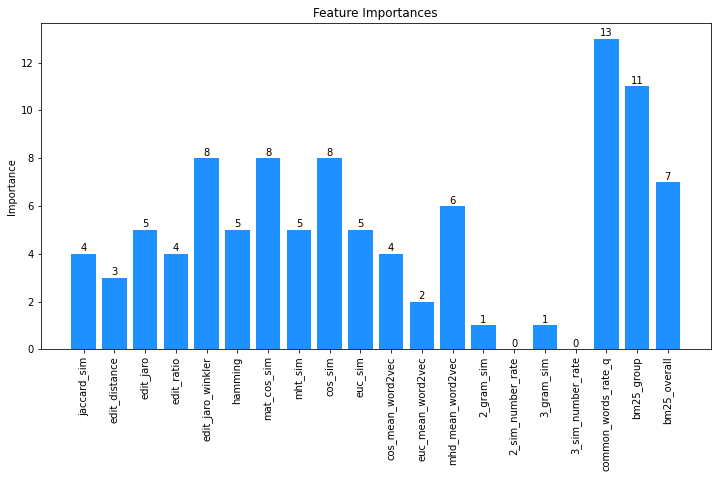

In [30]:
from matplotlib import pyplot as plt
model_path = model_folder + 'single_model'
model = pd.read_pickle(model_path)

trim_name = [trim[5:] for trim in feat_name]
importances = model.feature_importance()

plt.figure(figsize=(12,6))
plt.ylabel('Importance')
plt.title('LightGBM Feature Importances')
plt.bar(x = range(len(trim_name)),
        height = importances,
        tick_label = trim_name,
        color = 'dodgerblue',
        width = 0.8
       )
plt.xticks(rotation=90)
for x,y in enumerate(importances):
    plt.text(x,y+0.1,'%s' %round(y,1),ha='center')

plt.title("Feature Importances")
plt.savefig('./lgb_feature.png')
plt.show()

In [31]:
# Cross-validtion
cv_ret = lgb_cv_skl(train_x, train_y, valid_x, n_splits=5)

Fold Number: 1
Fold Number: 2
Fold Number: 3
Fold Number: 4
Fold Number: 5


In [ ]:
params = {
    'n_estimators': 400,
    'boosting_type': 'gbdt',
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'ndcg_at': [10],
    #'lambda_l1': 1,
    #'lambda_l2': 0.1,
    'learning_rate': 0.1,
    'feature_fraction': 1.0,
    'bagging_fraction': 0.8,
    # 'bagging_freq': 10,
    # 'tree_learner': 'feature',
    # 'verbose_eval': 200,
    'metric_freq': 10,
    'train_metric': True,
    'num_leaves': 120,
    'max_depth': 7,
    # 'min_child_samples': 30,
    'random_state': 2020,
    'num_threads': 16,
    'early_stopping_rounds': 50,
    'max_bin': 5,
    'min_data_in_left': 75,
}


def test_two_param():
    ret_dict = dict()
    attr1 = 'lambda_l1'
    attr2 = 'lambda_l2'
    test_params = {
        attr1: [1e-5,1e-3,1e-1,0.0,0.1,0.3,0.5,0.7,0.9,1.0],
        attr2: [1e-5,1e-3,1e-1,0.0,0.1,0.3,0.5,0.7,0.9,1.0]
    }

    for key1 in test_params[attr1]:
        for key2 in test_params[attr2]:
            params[attr1] = key1
            params[attr2] = key2
            model = lgb_train(params, train_x, train_y, valid_x, valid_y, train_group, valid_group)
            mrr = get_pred_mrr(model)
            print(f'{key1} {key2} {mrr}')
            ret_dict[(key1, key2)] = mrr
    
    return ret_dict

def test_one_param():
    ret_dict = dict()
    attr = 'n_estimators'
    test_params = {
        attr: [400, 410, 420, 430, 440, 450],
    }
    for key in test_params[attr]:
        params[attr] = key
        model = lgb_train(params, train_x, train_y, valid_x, valid_y, train_group, valid_group)
        mrr = get_pred_mrr(model)
        print(f'{key} {mrr}')
        ret_dict[key] = mrr
    return ret_dict

ret_dict = test_two_param()

# XGBoost Training

## Basic Configurations

In [119]:
model_folder = f'./model/XGB/{str(NEGATIVE_SCALE)}/'

params = {'learning_rate': 0.1, 'n_estimators': 400, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
          'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.2, 'reg_alpha': 0.1, 'reg_lambda': 0.05,
          'objective': 'rank:pairwise', 'eval_metric':'ndcg', 'random_state': 2020, 'n_jobs': 8,}

'''
    Single model training implementation of XGB
'''

def xgb_train(hyper_params, train_x, train_y, valid_x, valid_y, train_group, valid_group):
    model = xgb.sklearn.XGBRanker(**hyper_params)
    model.fit(train_x, train_y, train_group, verbose=False,
              eval_set=[(valid_x, valid_y)], eval_group=[valid_group],
              early_stopping_rounds=100)
    return model
    # pred = model.predict(valid_x)

'''   
    Cross-validation implementation based on sklearn
    * 5 Folds
'''
def xgb_cv_skl(train_x, train_y, test_x, n_splits=5):
    folds = KFold(n_splits=n_splits, shuffle=False)
    oof = np.zeros(train_x.shape[0])
    test_preds = np.zeros(test_x.shape[0])
    for fold_num, (train_idx, val_idx) in enumerate(folds.split(train_x, train_y)):
        print("Fold Number: {}".format(fold_num + 1))
        # Get training fold and validation fold
        train_fold_x, train_fold_y = train_x.iloc[train_idx], train_y.iloc[train_idx]
        validation_fold_x, validation_fold_y = train_x.iloc[val_idx], train_y.iloc[val_idx]
        # Get training groups
        train_group = get_group(training_pd_part.iloc[train_idx])
        validation_group = get_group(training_pd_part.iloc[val_idx])
        # Train model in this fold
        model = xgb_train(params, train_fold_x, train_fold_y, validation_fold_x, validation_fold_y, train_group, validation_group)
        # Save model
        model_path = f'{model_folder}fold_{fold_num}_model'
        pd.to_pickle(model, model_path)
        pickled_model = pd.read_pickle(model_path)
        oof[val_idx] = pickled_model.predict(validation_fold_x)
        test_preds += pickled_model.predict(test_x)

    return oof, test_preds / n_splits

## Training XGB

In [ ]:
test_params = {
             #'n_estimators': [400, 500, 600],
             # 'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
             # 'min_child_weight': [1, 2, 3, 4, 5, 6],
             #'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
             #'': ,
             #'': ,
            }
params = {'learning_rate': 0.1, 'n_estimators': 400, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
          'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.2, 'reg_alpha': 0.1, 'reg_lambda': 0.05,
          'objective': 'rank:pairwise', 'eval_metric':'ndcg', 'random_state': 2020, 'n_jobs': 8,}


def test_two_param():
    ret_dict = dict()
    attr1 = 'reg_alpha'
    attr2 = 'reg_lambda'
    test_params = {
        attr1: [0.05, 0.1, 1, 2, 3],
        attr2: [0]
    }

    for key1 in test_params[attr1]:
        for key2 in test_params[attr2]:
            params[attr1] = key1
            params[attr2] = key2
            model = xgb_train(params, train_x, train_y, valid_x, valid_y, train_group, valid_group)
            mrr = get_pred_mrr(model)
            print(f'{key1} {key2} {mrr}')
            ret_dict[(key1, key2)] = mrr
    
    return ret_dict

def test_one_param():
    ret_dict = dict()
    attr = 'learning_rate'
    test_params = {
        attr:  [0.12, 0.14, 0.16],
    }
    for key in test_params[attr]:
        params[attr] = key
        model = xgb_train(params, train_x, train_y, valid_x, valid_y, train_group, valid_group)
        mrr = get_pred_mrr(model)
        print(f'{key} {mrr}')
        ret_dict[key] = mrr
    return ret_dict

print(test_one_param())

In [117]:
single_model = xgb_train(params, train_x, train_y, valid_x, valid_y, train_group, valid_group)
model_path = f'{model_folder}single_model'
pd.to_pickle(single_model, model_path)

In [120]:
xgb_cv_skl(train_x, train_y, valid_x)

Fold Number: 1
Fold Number: 2
Fold Number: 3
Fold Number: 4
Fold Number: 5


(array([ 5.684412  , -4.23841238, -1.95727491, ..., -4.18361616,
        -3.99951315, -3.49529719]),
 array([ 6.04801722, -3.7674592 , -3.37124777, ..., -4.12425785,
        -4.49856939, -4.10422773]))

# CatBoost Training

## Basic Configurations

In [44]:
model_folder = f'./model/CAT/{str(NEGATIVE_SCALE)}/'

param = {'loss_function':'YetiRank',
         'learning_rate': 0.137538463021118,
         'iterations': 800,
         'depth': 8,
         'use_best_model':True,
         'random_seed': 2020,
         'eval_metric': 'NDCG',
         'l2_leaf_reg': 3.958039664583567,
         # 'one_hot_max_size' : 20,
         'bagging_temperature' :  5.7513358957861715,
         # 'max_ctr_complexity': 4,
         'thread_count': 64,
         'early_stopping_rounds': 100,
        }

def cat_train(hyper_params, train_x, train_y, valid_x, valid_y, train_pd, valid_pd):
    model = CatBoost(hyper_params)
    train_pool = Pool(data=train_x, label=train_y, group_id=train_pd['query_id'])
    validation_pool = Pool(data=valid_x, label=valid_y, group_id=valid_pd['query_id'])
    model.fit(train_pool, eval_set=validation_pool, logging_level='Silent', plot=False)
    return model
    # pred = model.predict(valid_x)

'''   
    Cross-validation implementation based on sklearn
    * 5 Folds
'''
def cat_cv_skl(train_x, train_y, test_x, n_splits=5):
    folds = KFold(n_splits=n_splits, shuffle=False)
    oof = np.zeros(train_x.shape[0])
    test_preds = np.zeros(test_x.shape[0])
    for fold_num, (train_idx, val_idx) in enumerate(folds.split(train_x, train_y)):
        print("Fold Number: {}".format(fold_num + 1))
        # Get training fold and validation fold
        train_fold_x, train_fold_y = train_x.iloc[train_idx], train_y.iloc[train_idx]
        validation_fold_x, validation_fold_y = train_x.iloc[val_idx], train_y.iloc[val_idx]
        # Get training groups
        train_group = training_pd_part.iloc[train_idx]
        validation_group = training_pd_part.iloc[val_idx]
        # Train model in this fold
        model = cat_train(param, train_fold_x, train_fold_y, validation_fold_x, validation_fold_y, train_group, validation_group)
        # Save model
        model_path = f'{model_folder}fold_{fold_num}_model'
        pd.to_pickle(model, model_path)
        pickled_model = pd.read_pickle(model_path)
        oof[val_idx] = pickled_model.predict(validation_fold_x)
        test_preds += pickled_model.predict(test_x)

    return oof, test_preds / n_splits

## Training CatBoost

In [43]:
single_model = cat_train(param, train_x, train_y, valid_x, valid_y, train_group, valid_group)
mrr = get_pred_mrr(single_model)
print(mrr)
model_path = f'{model_folder}single_model'
pd.to_pickle(single_model, model_path)

0.38279920634920706


In [45]:
cat_oof, cat_pred = cat_cv_skl(train_x, train_y, valid_x)

Fold Number: 1
Fold Number: 2
Fold Number: 3
Fold Number: 4
Fold Number: 5


In [30]:
from bayes_opt import BayesianOptimization
# Bayesian Optimization
def bayesian_cat_train(l2_leaf_reg, bagging_temperature, learning_rate):
    params = {'loss_function':'YetiRank',
         'learning_rate': learning_rate,
         'iterations': 800,
         'depth': 8,
         'use_best_model':True,
         'random_seed': 2020,
         'eval_metric': 'NDCG',
         'l2_leaf_reg': l2_leaf_reg,
         # 'one_hot_max_size' : 20,
         'bagging_temperature' : bagging_temperature,
         # 'max_ctr_complexity': 4,
         'thread_count': 64,
         'early_stopping_rounds': 100,
    }
 
    model = cat_train(params, train_x, train_y, valid_x, valid_y, train_group, valid_group)
    mrr = get_pred_mrr(model)
    return mrr
 
cat_opt = BayesianOptimization(bayesian_cat_train, {
                                'l2_leaf_reg': (1, 9),
                                'bagging_temperature': (1, 10),
                                'learning_rate': (0.1, 0.2),
                            })
 
cat_opt.maximize(init_points=5, n_iter=15)

|   iter    |  target   | baggin... | l2_lea... | learni... |
-------------------------------------------------------------
|  1        |  0.3774   |  8.418    |  7.165    |  0.1286   |
|  2        |  0.3768   |  4.715    |  5.565    |  0.1135   |
|  3        |  0.374    |  5.455    |  4.538    |  0.1146   |
|  4        |  0.3811   |  6.014    |  3.58     |  0.1678   |
|  5        |  0.3707   |  2.442    |  3.977    |  0.127    |
|  6        |  0.3798   |  3.535    |  7.113    |  0.1029   |
|  7        |  0.3782   |  1.743    |  1.669    |  0.1482   |
|  8        |  0.3817   |  5.398    |  3.677    |  0.1758   |
|  9        |  0.3805   |  6.031    |  3.594    |  0.1544   |
|  10       |  0.3823   |  5.702    |  3.571    |  0.1971   |
|  11       |  0.3818   |  5.856    |  3.291    |  0.1998   |
|  12       |  0.3803   |  5.284    |  3.253    |  0.2      |
|  13       |  0.3821   |  4.868    |  3.663    |  0.2      |
|  14       |  0.3811   |  4.522    |  3.297    |  0.1263   |
|  15   

In [41]:
print(cat_opt.res[17]['params'])

{'bagging_temperature': 5.7513358957861715, 'l2_leaf_reg': 3.958039664583567, 'learning_rate': 0.137538463021118}
